
!['Welcome cado'](https://i.imgur.com/R3wA2ew.jpg)





# **Introduction**


Hi! In this kernel I am going to perform an exploratory data analysis of an avocado price in the US dataset available in [Kaggle](https://www.kaggle.com/neuromusic/avocado-prices). Afterwards, I will attempt to predict avocado price changes using group and lag based feature engineering with gradient boosting libraries and linear regression

After creating the first level prediction from the gradient boosting libraries and linear regression, I will use a simple ensemble that use the output of the first level to predict the average price change



# **Loading Data and Exploratory Data Analysis**

First we need to load some libraries and read the data.

In [1]:

import numpy as np
import pandas as pd


#visualization libraries
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:

sns.set(style="darkgrid")
data = pd.read_csv('avocado.csv') #read to data
data = data.drop(['Unnamed: 0'], axis = 1) #drop the useless column

names = ["date", "avprice", "totalvol", "small","large","xlarge","totalbags","smallbags","largebags","xlargebags","type","year","region"] #get new column names
data = data.rename(columns=dict(zip(data.columns, names))) #rename columns
data['date'] = pd.to_datetime(data['date'])
MIN_DATE=data['date'].min().date()
def diff_month(d1):
    return (d1.year - MIN_DATE.year) * 12 + d1.month - MIN_DATE.month
data['month_id'] = data['date'].apply(diff_month)
data['month'] = data['month_id'].apply(lambda x: (x % 12))

data.head()

,date,avprice,totalvol,small,large,xlarge,totalbags,smallbags,largebags,xlargebags,type,year,region,month_id,month
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,11,11
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,11,11
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,11,11
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,11,11
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,10,10


### Let's explore some basic properties of the dataset and check for missing values

In [3]:
data.describe()

,avprice,totalvol,small,large,xlarge,totalbags,smallbags,largebags,xlargebags,year,month_id,month
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899,18.951997,5.177215
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938,11.206987,3.534130
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000,0.000000,0.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000,9.000000,2.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000,19.000000,5.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000,29.000000,8.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000,38.000000,11.000000


In [4]:
data.isnull().sum()

date          0
avprice       0
totalvol      0
small         0
large         0
xlarge        0
totalbags     0
smallbags     0
largebags     0
xlargebags    0
type          0
year          0
region        0
month_id      0
month         0
dtype: int64

### Let's have a look at the average price distribution of all the avocadoes


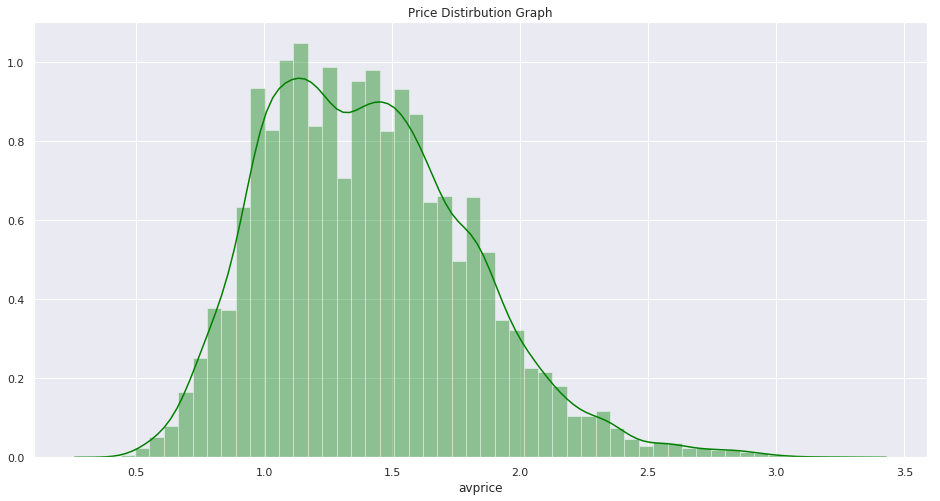

In [5]:
plt.figure(figsize=(16,8))
plt.title("Price Distirbution Graph")
sns.distplot(data["avprice"], color = 'green')


## We can also have a look at the price distribution of avocadoes by type (organic vs conventional)

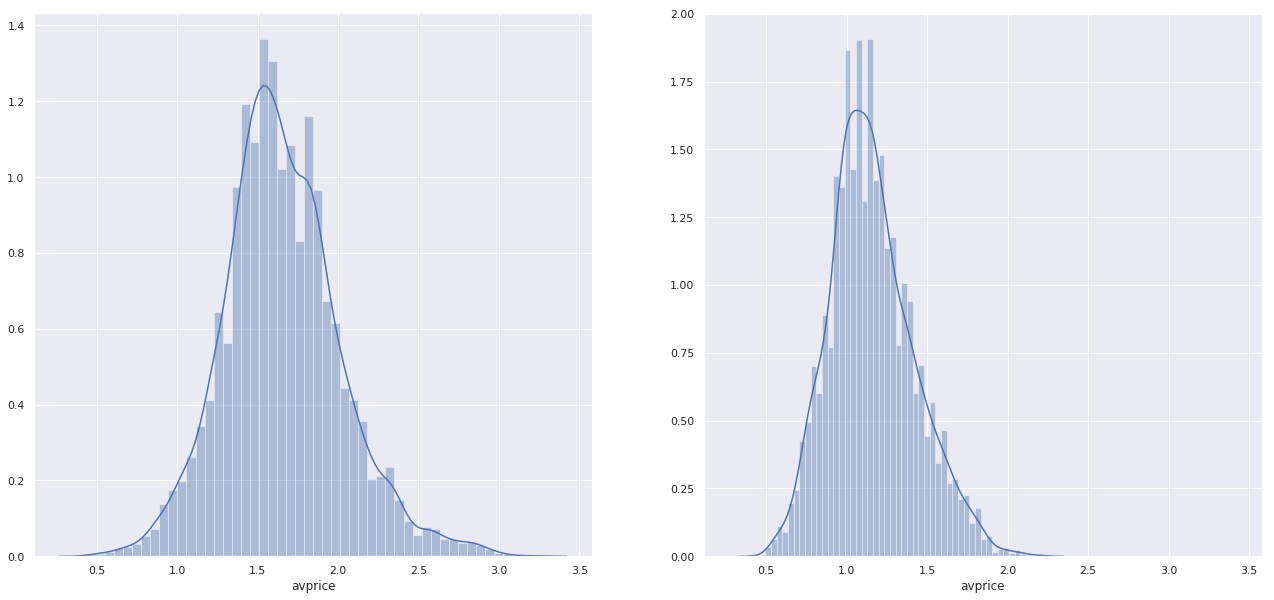

In [6]:

fig, ax = plt.subplots(1,2, figsize=(22, 10), sharex=True)

sns.distplot(data[data['type']=='organic']['avprice'], ax=ax[0])
sns.distplot(data[data['type']=='conventional']['avprice'], ax=ax[1])


## Now let's have a look at how the price varies by region.

To do that, we will first see the mean average price in each region for the whole dataset and then we look into the mean price change over time by region

To do that, let's change the regions to numerical values for convenience

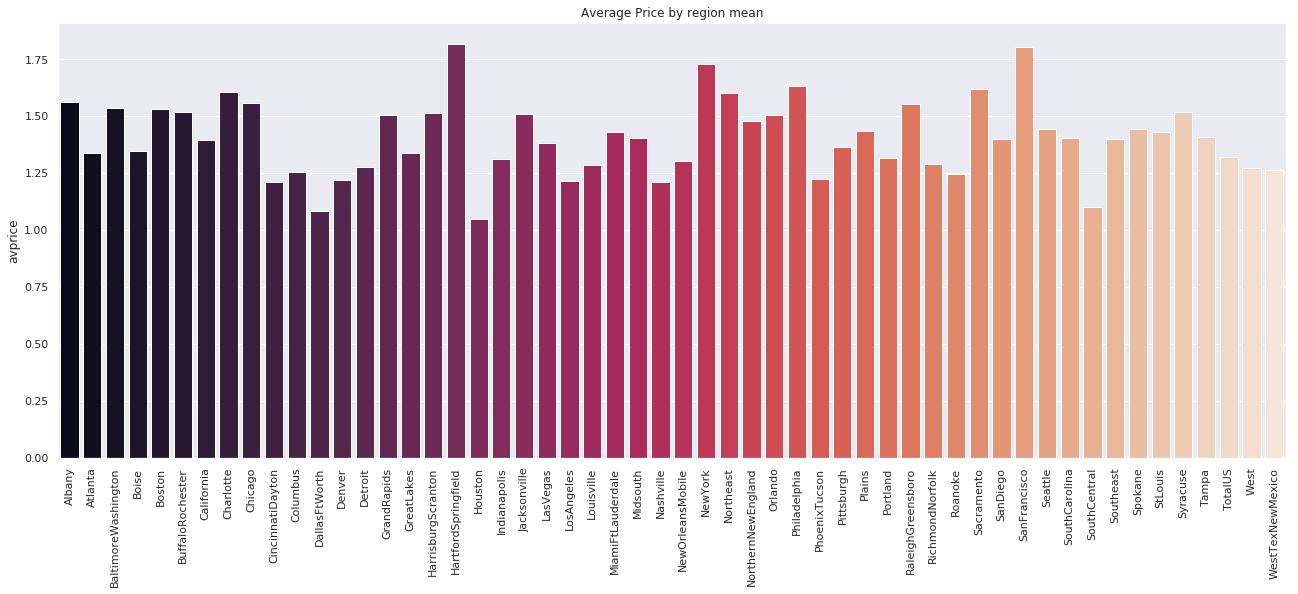

In [7]:
regions = list(data['region'].unique())
types = list(data['type'].unique())

f_type = lambda x : types.index(x)
f_region = lambda x : regions.index(x)

data['region_id']=data['region'].apply(f_region)
data['type_id']=data['type'].apply(f_type)

gp_region_price_mean = data.groupby(['region_id'], as_index=False)['avprice'].mean()

plt.subplots(figsize=(22, 8))
plt.xticks(rotation=90)
sns.barplot(x=regions, y="avprice", data=gp_region_price_mean, palette="rocket").set_title("Average Price by region mean")
plt.show()

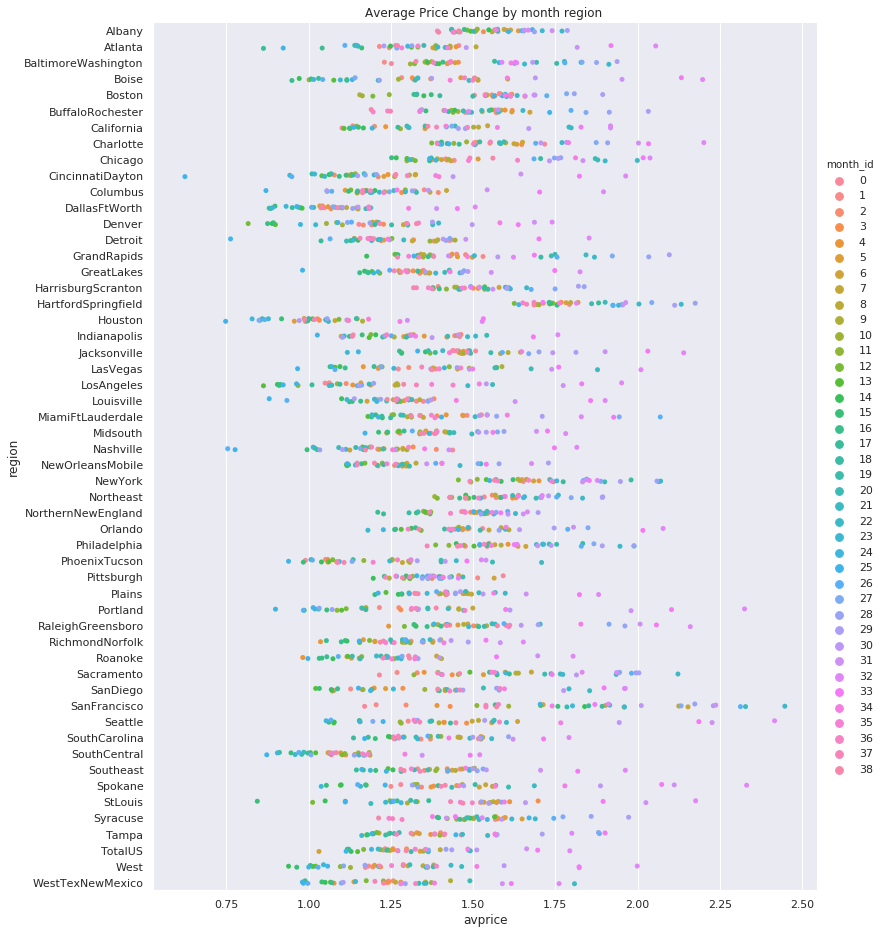

In [8]:
gp_month_region_price_mean = data.groupby(['region','month_id'], as_index=False)['avprice'].mean()
sns.catplot('avprice','region', data=gp_month_region_price_mean  ,hue='month_id',height=13,aspect=0.9,)
plt.title("Average Price Change by month region ")
plt.show()

Now that we have identified that avocado price varies according to the region and date of the purchase, let's look at the avocado price change over time and how it relates to the total volume of avocado


You can clearly see two different clusters in there because the dataset contain information about cities (LosAngeles) and regions (California, TotalUS)


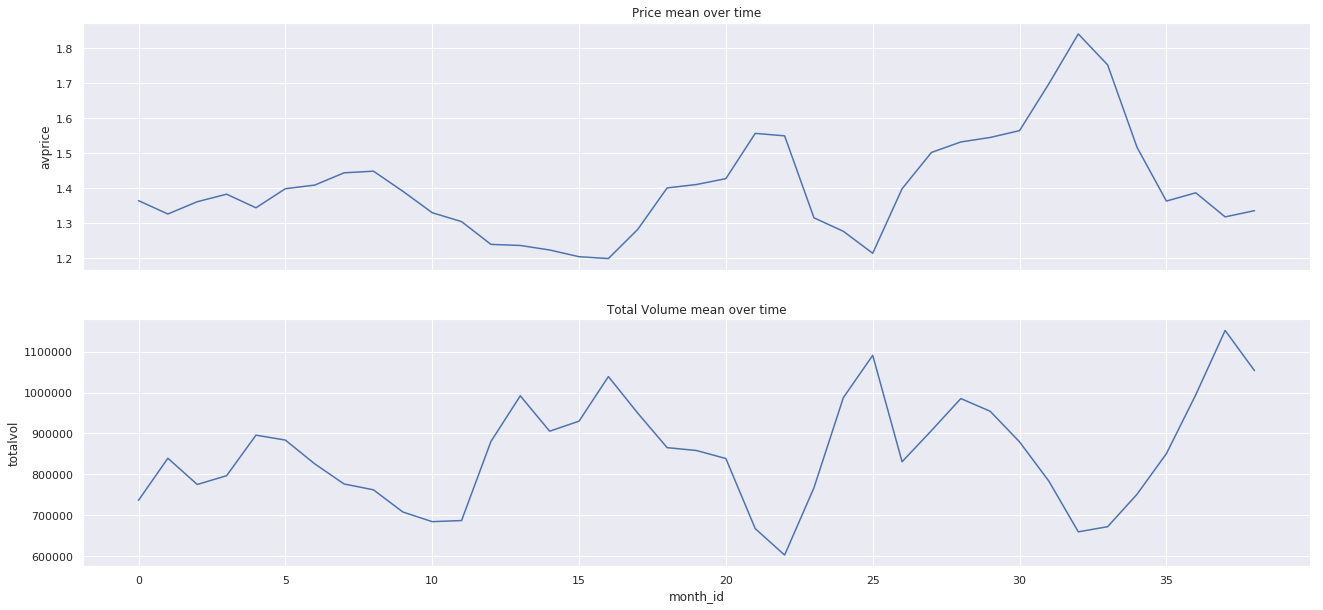

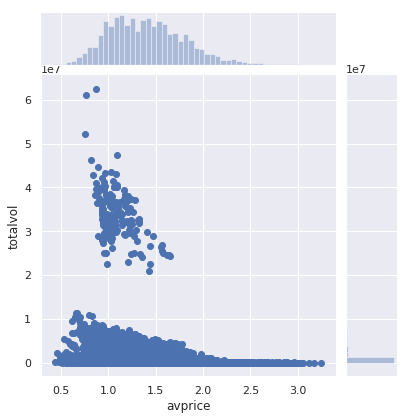

In [9]:
gp_price_mean = data.groupby(['month_id'], as_index=False)['avprice'].mean()
gp_volume_mean = data.groupby(['month_id'], as_index=False)['totalvol'].mean()
gp_volume_sum = data.groupby(['month_id'], as_index=False)['totalvol'].sum()


f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month_id", y="avprice", data=gp_price_mean, ax=axes[0]).set_title("Price mean over time")
sns.lineplot(x="month_id", y="totalvol", data=gp_volume_mean, ax=axes[1]).set_title("Total Volume mean over time")
sns.jointplot(x="avprice", y="totalvol", data=data)
plt.show()


# Feature Engineering

## Group Based Features

I will extract the min/max price of avocados by region/month first, afterwards I am going to use a rolling window of 6 (correspending to 1.5 month) to calculate the mean,median and standard deviation of the average price.


In [10]:
#Min/Max by region/month
gp_avprice_change = data.sort_values('date').groupby(['month','region','type'], as_index=False).agg({'avprice':[np.min, np.max]})
gp_avprice_change.columns = ['month','region','type','avprice_month_min','avprice_month_max']



#Rolling window features
data_monthly = pd.merge(data, gp_avprice_change, on=['month','region','type'], how='left')
data_monthly['avprice_monthly_mean'] = data['avprice'].rolling(window=6,min_periods=1).mean()
data_monthly['avprice_monthly_std'] = data['avprice'].rolling(window=6,min_periods=1).std()
data_monthly['avprice_monthly_median'] = data['avprice'].rolling(window=6,min_periods=1).median()
data_monthly.fillna(0, inplace=True)

data_monthly.sort_values('date').head()

,date,avprice,totalvol,small,large,xlarge,totalbags,smallbags,largebags,xlargebags,...,region,month_id,month,region_id,type_id,avprice_month_min,avprice_month_max,avprice_monthly_mean,avprice_monthly_std,avprice_monthly_median
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,...,Southeast,0,0,46,1,1.32,1.83,1.715000,0.129885,1.770
9593,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,...,Chicago,0,0,8,1,1.34,1.85,1.703333,0.154876,1.785
10009,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,...,HarrisburgScranton,0,0,16,1,1.32,2.00,1.731667,0.116519,1.675
1819,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,...,Pittsburgh,0,0,34,0,1.01,1.54,1.413333,0.115873,1.425
9333,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,...,Boise,0,0,3,1,1.04,1.82,1.520000,0.175613,1.440


## Lag based features

Now I am going to append the last three prices observed to each row, then calculate the price trend 

In [11]:



# Lag based features.
lag_list = [1, 2, 3]
data_monthly.sort_values('date',inplace = True) 
lag_monthly = pd.DataFrame()
for lag in lag_list:
    ft_name = ('avprice_shifted%s' % lag)
    data_monthly[ft_name] = data_monthly.groupby(['region','type','month'])['avprice'].shift(lag)
    data_monthly[ft_name].fillna(0, inplace=True)
    
data_monthly['price_trend'] = data_monthly['avprice']
data_monthly['price_trend'] /= len(lag_list) + 1

for lag in lag_list:
    ft_name = ('avprice_shifted%s' % lag)
    data_monthly['price_trend'] -= data_monthly[ft_name]




data_monthly.sort_values(['region','type','date']).tail(10)

,date,avprice,totalvol,small,large,xlarge,totalbags,smallbags,largebags,xlargebags,...,type_id,avprice_month_min,avprice_month_max,avprice_monthly_mean,avprice_monthly_std,avprice_monthly_median,avprice_shifted1,avprice_shifted2,avprice_shifted3,price_trend
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,...,1,1.18,1.93,1.651667,0.121065,1.600,1.93,1.62,1.30,-4.3825
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,...,1,1.18,1.93,1.596667,0.063140,1.570,1.87,1.93,1.62,-4.9925
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,...,1,1.16,1.77,1.571667,0.030605,1.565,1.16,1.24,1.40,-3.3925
18243,2018-02-11,1.57,15986.17,1924.28,1368.32,0.00,12693.57,12437.35,256.22,0.0,...,1,1.16,1.77,1.560000,0.010954,1.560,1.63,1.16,1.24,-3.6375
18242,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,...,1,1.16,1.77,1.568333,0.027142,1.560,1.57,1.63,1.16,-3.9700
18241,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,...,1,1.16,1.77,1.555000,0.045497,1.560,1.56,1.57,1.63,-4.3675
18240,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,...,1,1.11,1.84,1.596667,0.118265,1.560,1.11,1.11,1.15,-2.9850
18239,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,...,1,1.11,1.84,1.645000,0.146390,1.590,1.54,1.11,1.11,-3.3700
18238,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,...,1,1.11,1.84,1.685000,0.151228,1.710,1.56,1.54,1.11,-3.8200
18237,2018-03-25,1.62,15303.40,2325.30,2171.66,0.00,10806.44,10569.80,236.64,0.0,...,1,1.11,1.84,1.660000,0.184716,1.710,1.56,1.56,1.54,-4.2550


## Splitting the data

After splitting the data we can encode the region, month and year mean price observed in the trainning the data

In [12]:

train_set = data_monthly.query('month_id >= 3 and month_id < 33').copy()
validation_set = data_monthly.query('month_id >= 33 and month_id <= 35').copy()
test_set = data_monthly.query('month_id > 35').copy()

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])




Train set records: 14037
Validation set records: 1512
Test set records: 1296


In [13]:
#encoding means
gp_region_mean =  train_set.groupby(['region','type'], as_index=False)['avprice'].agg({'avprice': ['mean']})
gp_region_mean.columns = ['region','type','region_mean']
gp_month_mean = train_set.groupby(['month','type'], as_index=False)['avprice'].agg({'avprice': ['mean']})
gp_month_mean.columns = ['month','type','month_mean']
gp_year_mean = train_set.groupby(['year','type'], as_index=False)['avprice'].agg({'avprice': ['mean']})
gp_year_mean.columns = ['year','type','year_mean']


#Building Train / Validation / Test sets
train_set = pd.merge(train_set, gp_region_mean, on=['region','type'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month','type'],how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year','type'], how='left')

validation_set = pd.merge(validation_set, gp_region_mean, on=['region','type'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month','type'],how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year','type'], how='left')

test_set = pd.merge(validation_set, gp_region_mean, on=['region','type'], how='left')
test_set = pd.merge(validation_set, gp_month_mean, on=['month','type'],how='left')
test_set = pd.merge(validation_set, gp_year_mean, on=['year','type'], how='left' , suffixes=['','_'])



# Removing Extra Attributes 
X_train = train_set.drop(['avprice','type','date','month_id','region'], axis=1)
Y_train = train_set['avprice']
X_validation = validation_set.drop(['avprice','type','date','month_id','region'], axis=1)
Y_validation = validation_set['avprice']

int_features = ['month','year','type_id','region_id']
X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

Y_test = test_set['avprice']
X_test = test_set.drop(['avprice','type','date','month_id','region','year_mean_'], axis=1)


X_test.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512 entries, 0 to 1511
Data columns (total 24 columns):
totalvol                  1512 non-null float64
small                     1512 non-null float64
large                     1512 non-null float64
xlarge                    1512 non-null float64
totalbags                 1512 non-null float64
smallbags                 1512 non-null float64
largebags                 1512 non-null float64
xlargebags                1512 non-null float64
year                      1512 non-null int64
month                     1512 non-null int64
region_id                 1512 non-null int64
type_id                   1512 non-null int64
avprice_month_min         1512 non-null float64
avprice_month_max         1512 non-null float64
avprice_monthly_mean      1512 non-null float64
avprice_monthly_std       1512 non-null float64
avprice_monthly_median    1512 non-null float64
avprice_shifted1          1512 non-null float64
avprice_shifted2          1512 non-nu

/home/marouane/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


# Avocado price prediction

I will use two gradient boosting models and linear regression to predict the avocado price

Afterwards I will use an ensemble regressor using the output of all three models to see if we can fine tune the predictions


## Catboost model

In [14]:
cat_features = np.where(X_train.dtypes != np.float)[0]


catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)


catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

0:	learn: 1.4194157	test: 1.5458519	best: 1.5458519 (0)	total: 111ms	remaining: 55.4s
50:	learn: 0.3589213	test: 0.4377779	best: 0.4377779 (50)	total: 1.03s	remaining: 9.12s
100:	learn: 0.1683611	test: 0.2266411	best: 0.2266411 (100)	total: 1.94s	remaining: 7.65s
150:	learn: 0.1447723	test: 0.1915335	best: 0.1915335 (150)	total: 2.68s	remaining: 6.19s
200:	learn: 0.1384592	test: 0.1842544	best: 0.1842544 (200)	total: 3.52s	remaining: 5.23s
250:	learn: 0.1347531	test: 0.1817332	best: 0.1817332 (250)	total: 4.32s	remaining: 4.28s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.18137972
bestIteration = 263

Shrink model to first 264 iterations.


## Evaluating the models

To evaluate the model, we look at the joint distribution of the predicted values and the true values of the average price, the model does a good job at predicting if the points are close to the fitted line

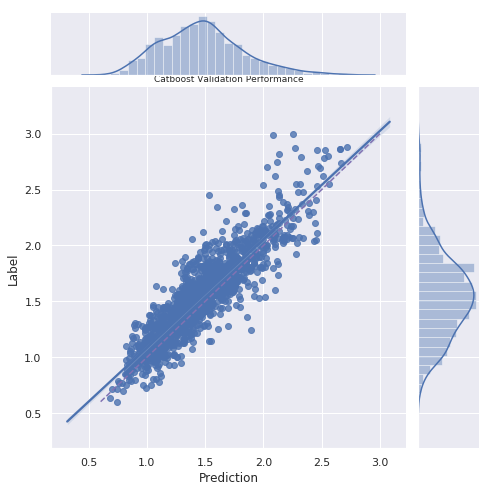

In [15]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
model_performance_sc_plot(catboost_val_pred, Y_validation, 'Catboost Validation Performance')

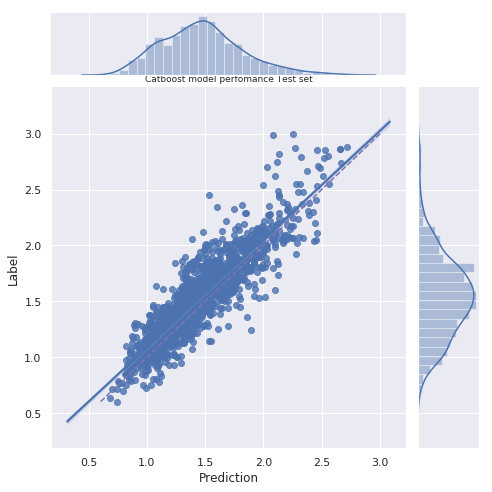

In [16]:
model_performance_sc_plot(catboost_test_pred, Y_test, 'Catboost model perfomance Test set')

## XGBoost

[0]	validation_0-rmse:0.896827	validation_1-rmse:1.01286
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.191617	validation_1-rmse:0.24817
[40]	validation_0-rmse:0.151212	validation_1-rmse:0.184965
[60]	validation_0-rmse:0.146079	validation_1-rmse:0.177089
[80]	validation_0-rmse:0.142858	validation_1-rmse:0.172933
[100]	validation_0-rmse:0.140431	validation_1-rmse:0.172216
[120]	validation_0-rmse:0.138528	validation_1-rmse:0.170593
[140]	validation_0-rmse:0.137013	validation_1-rmse:0.171502
Stopping. Best iteration:
[120]	validation_0-rmse:0.138528	validation_1-rmse:0.170593



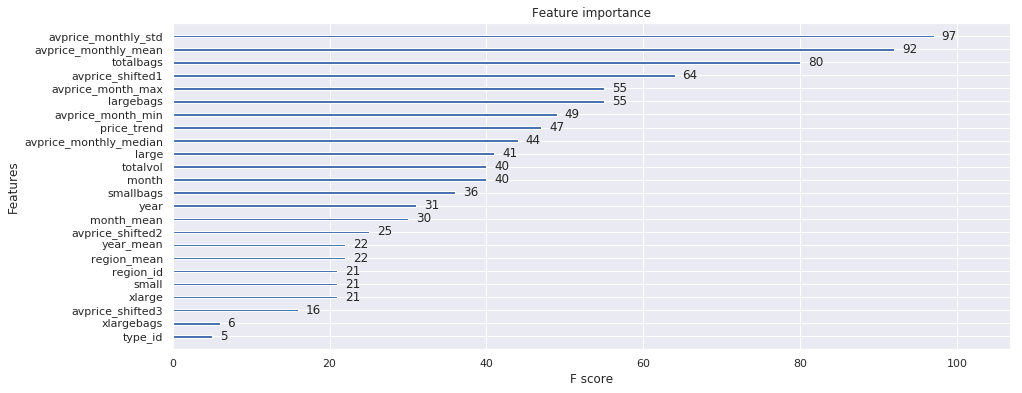

In [17]:
xgb_model = XGBRegressor(max_depth=20, 
                         n_estimators=600, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.2, 
                         seed=0)
xgb_model.fit(X_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(X_train, Y_train), (X_validation, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)


plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_validation)
xgb_test_pred = xgb_model.predict(X_test)
plt.show()

xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_validation)
xgb_test_pred = xgb_model.predict(X_test)


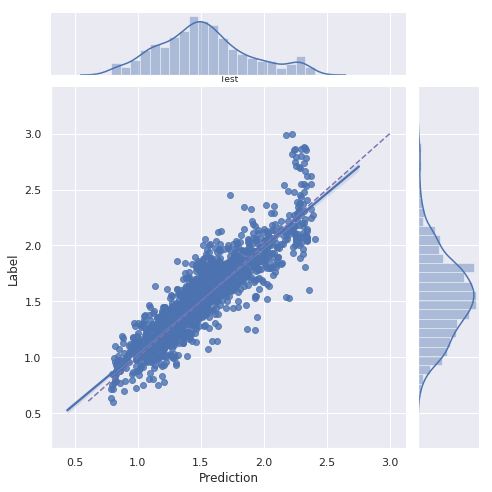

In [18]:
model_performance_sc_plot(xgb_test_pred, Y_test, 'Test')

## Linear Regression

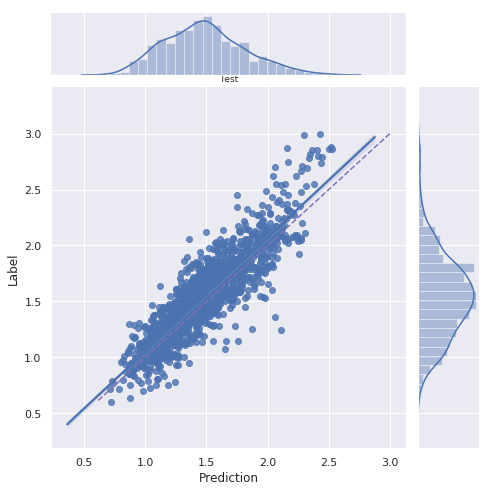

In [19]:
# Use only part of features on linear Regression.
lr_features = ['totalbags','year', 'month', 'region_id', 'type_id', 'avprice_monthly_mean',
       'avprice_monthly_std', 'price_trend','region_mean','avprice_month_min', 'avprice_month_max', 
       'month_mean', 'year_mean']
               
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)
model_performance_sc_plot(lr_test_pred, Y_test, 'Test')

It seems like most of the model are doing a good job at predicting the result, let's have a quick look at how the predictions vary compared to the true values for linear regression

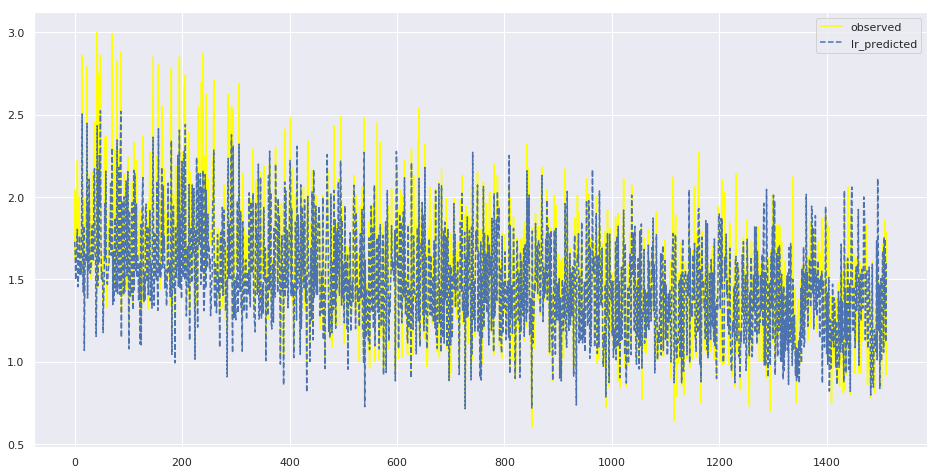

In [20]:
plt.figure(figsize=(16,8))


plt.plot(Y_test, label='observed',color = 'yellow')
plt.plot(lr_test_pred, '--',label='lr_predicted')

plt.legend(loc='best')
plt.show()


# Ensembling

Now that we have 3 sets of predictions, let's create a simple ensemble regressor by using linear regression on the predicted values

To do so we have to build a new Test and Training set (for the sake of simplicity, I will only use the validation data as training data for the ensemble) 

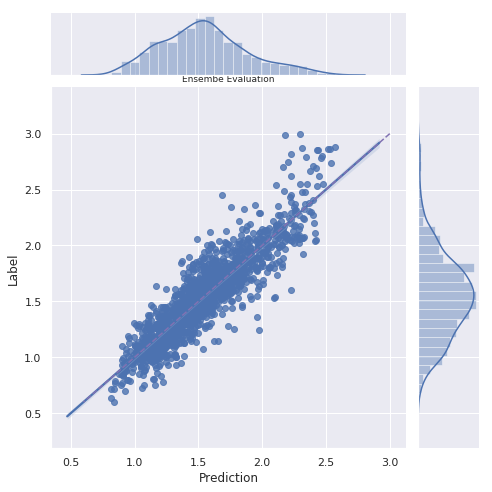

In [21]:
train_ensemble = validation_set[['avprice']].copy()
train_ensemble['cat'] = catboost_val_pred
train_ensemble['xgb'] =  xgb_val_pred
train_ensemble['lr'] =  lr_val_pred

# Drop label from dataset.
train_ensemble.drop('avprice', axis=1, inplace=True)


test_ensemble = test_set[['avprice']].copy()
test_ensemble['cat'] = catboost_test_pred
test_ensemble['xgb'] =  xgb_test_pred
test_ensemble['lr'] =  lr_test_pred

# Drop label from dataset.
test_ensemble.drop('avprice', axis=1, inplace=True)
test_ensemble.head()

ensemble_model = LinearRegression(n_jobs=-1)

ensemble_model.fit(train_ensemble, Y_validation)


ensemble_pred = ensemble_model.predict(test_ensemble)


model_performance_sc_plot(ensemble_pred,Y_test,'Ensembe Evaluation')

# Visualizing the results

## Predictions by region and type over time vs True Values

We can see that the predictions are not picking up some sharp variation in the average price (blue line) change, however they do a good job at picking up trends. Overall, they give a good approximation of the price

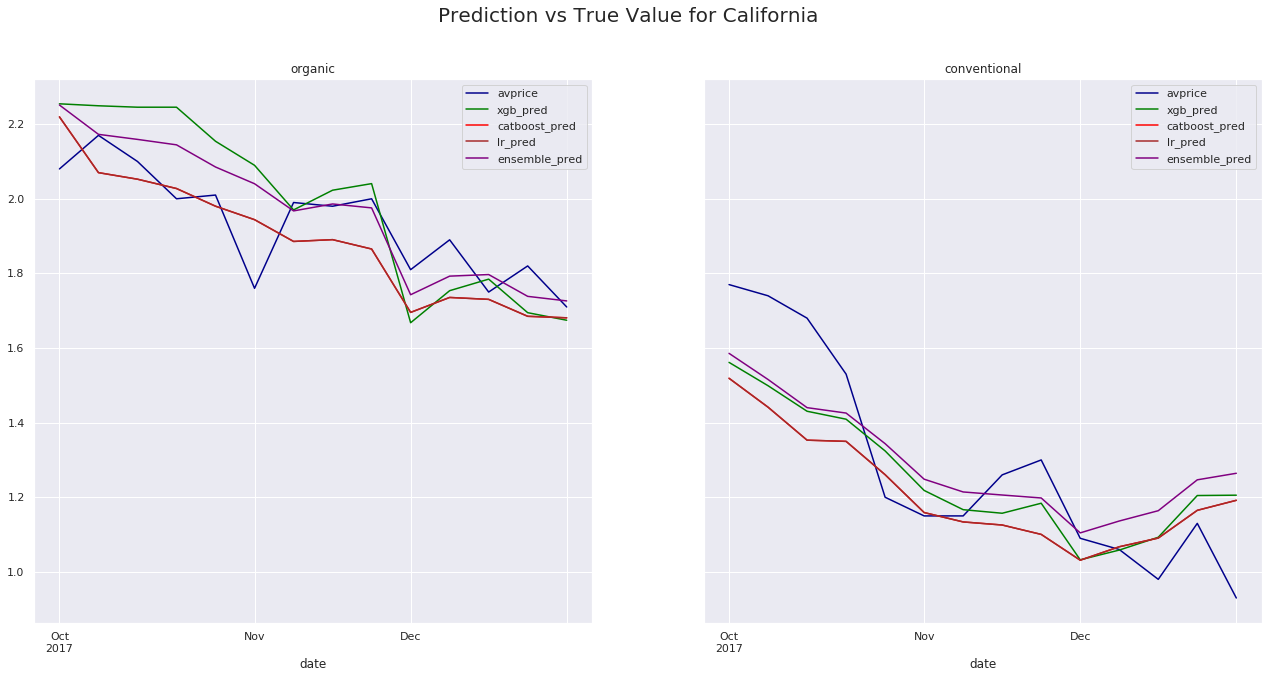

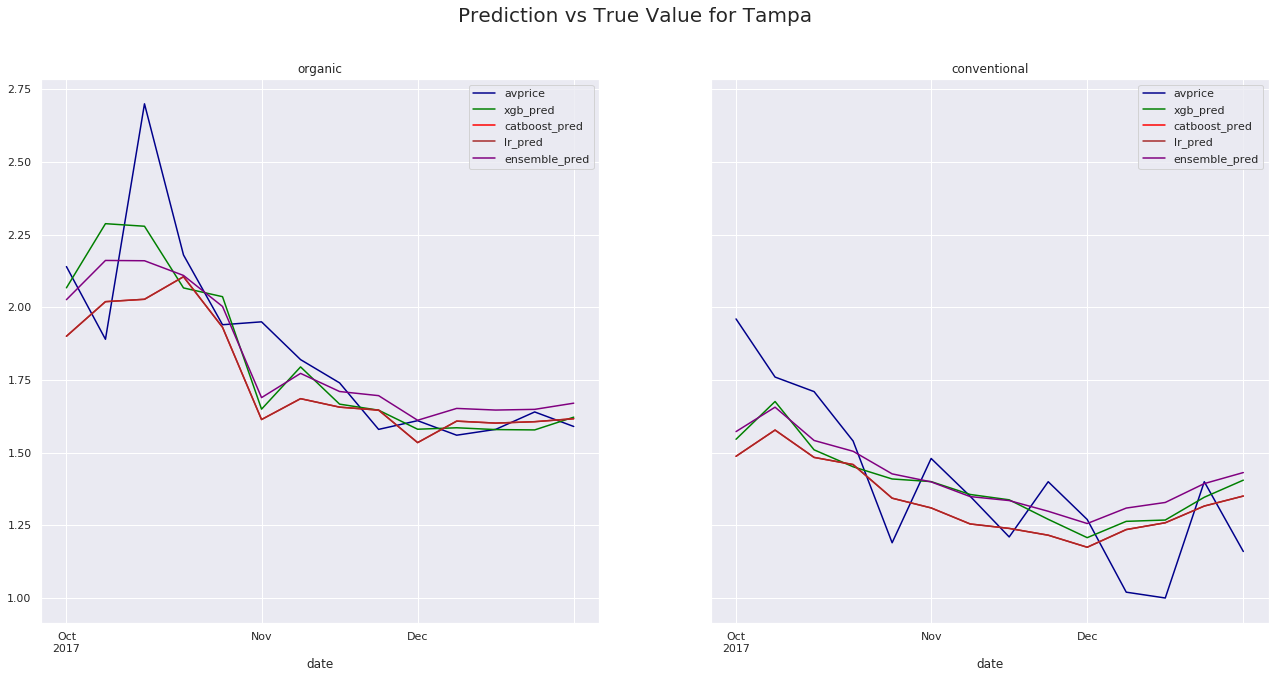

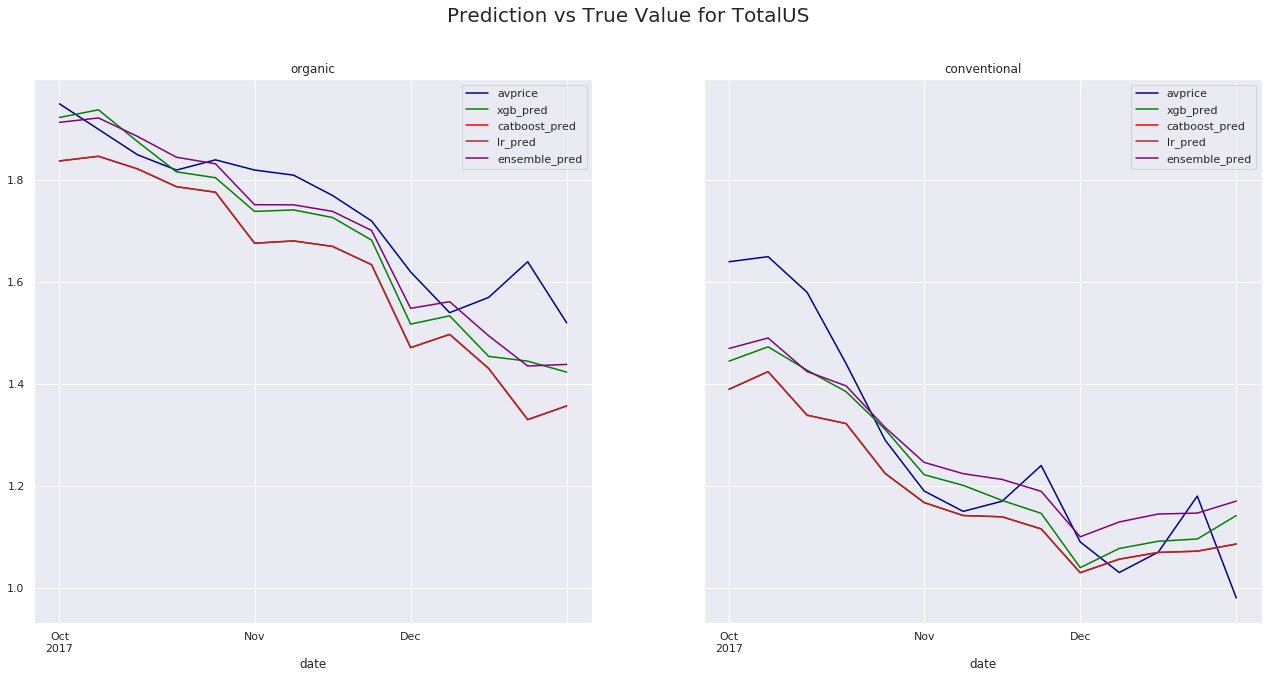

In [22]:
predictions = test_set[['date','type_id','region_id','avprice']].copy()
predictions['xgb_pred'] = xgb_test_pred
predictions['catboost_pred'] = catboost_test_pred
predictions['lr_pred'] = catboost_test_pred
predictions['ensemble_pred'] = ensemble_pred



def plot_region_pred(region):
    index = regions.index(region)
    organic = predictions.query('type_id == 1 and region_id == @index').copy()
    conventional = predictions.query('type_id == 0 and region_id == @index').copy()
    fig, ax = plt.subplots(1,2, figsize=(22, 10), sharex=True, sharey=True)
    organic.plot(x='date',y=['avprice','xgb_pred','catboost_pred','lr_pred','ensemble_pred'],color=['DarkBlue','green','red','brown','purple'],ax=ax[0],title='organic')
    conventional.plot(x='date',y=['avprice','xgb_pred','catboost_pred','lr_pred','ensemble_pred'],color=['DarkBlue','green','red','brown','purple'],ax=ax[1],title='conventional')
    title = 'Prediction vs True Value for '+ region
    fig.suptitle(title, fontsize=20)


plot_region_pred('California')
plot_region_pred('Tampa')
plot_region_pred('TotalUS')


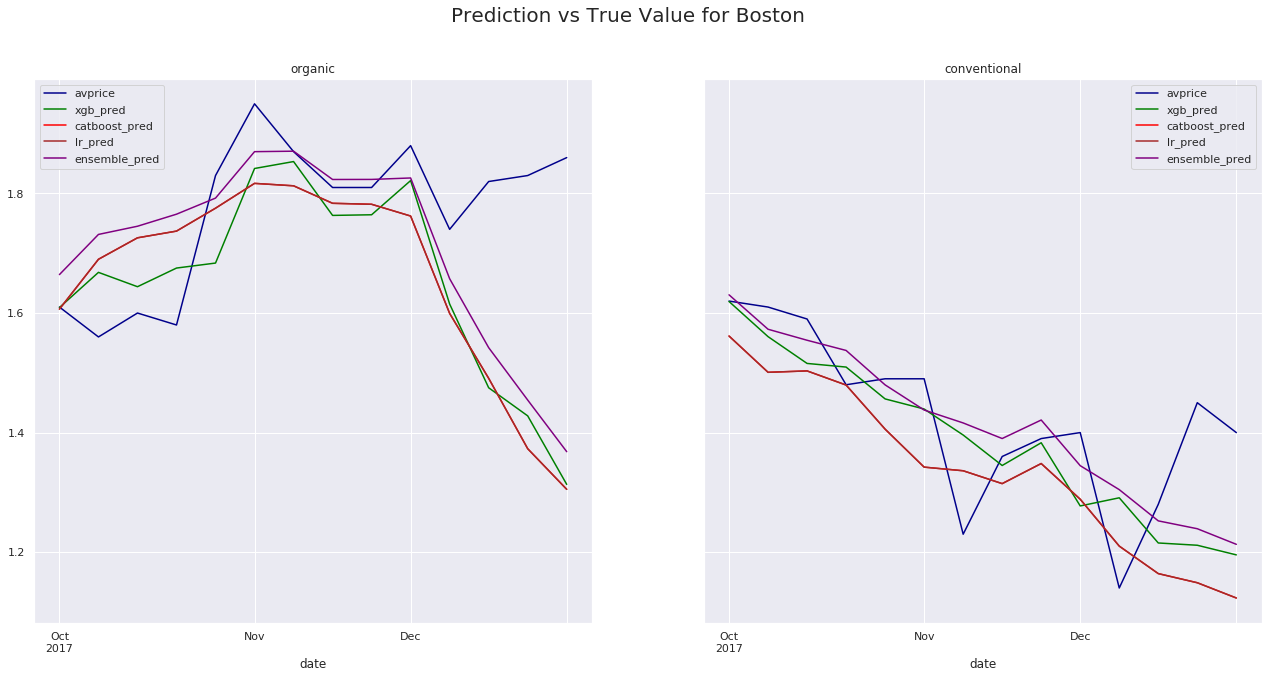

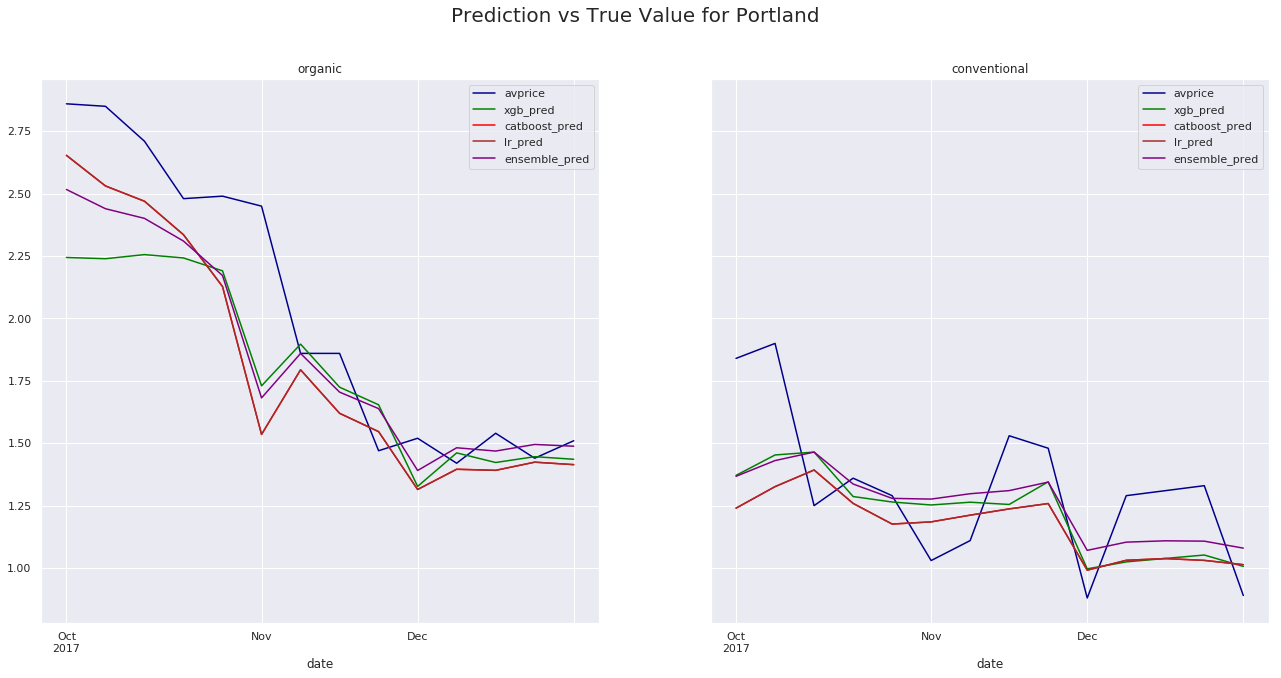

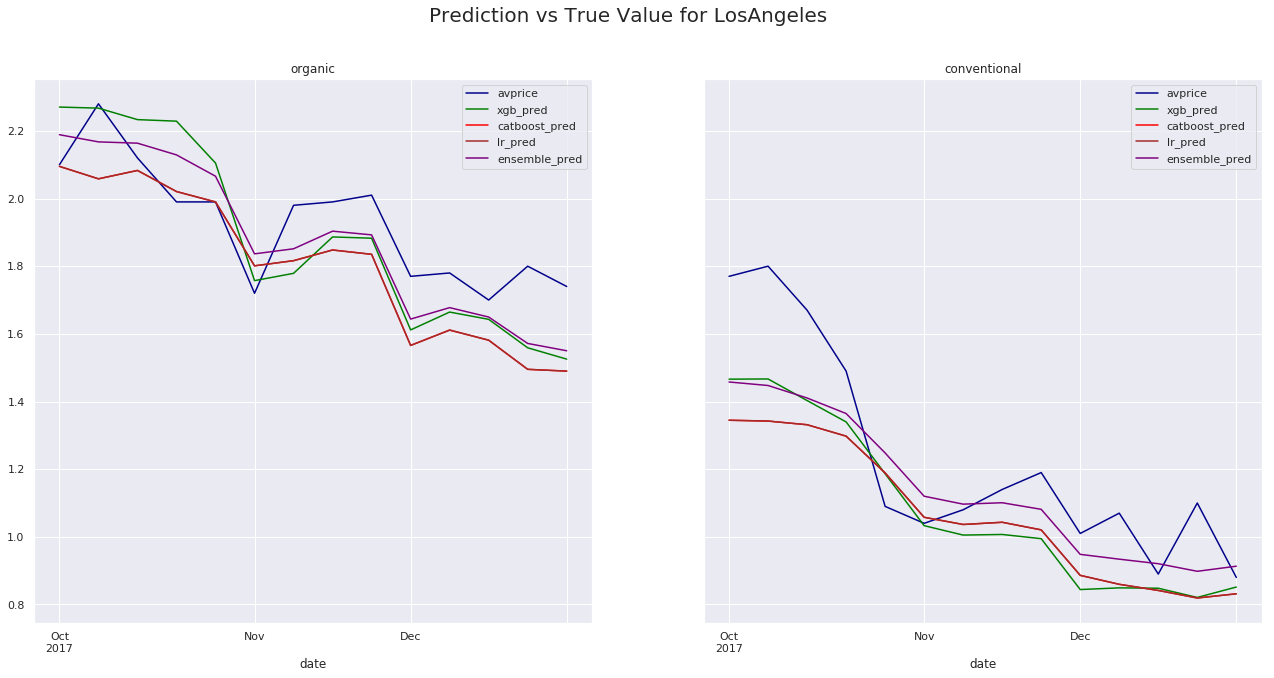

In [23]:
plot_region_pred('Boston')
plot_region_pred('Portland')
plot_region_pred('LosAngeles')

Thank you for taking the time to read this ^^


#### Sources: 

[Avocado-prices Dataset](https://www.kaggle.com/neuromusic/avocado-prices)

https://www.kaggle.com/yemregundogmus/avocado-prices-analysis-and-prediction

[model stacking feature engineering and eda](https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda/)
